# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [86]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer
# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [87]:
# Mount Google drive to access the dataset
# Run the below code if you using google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
# Load the image file of dataset
images = np.load('/content/drive/MyDrive/AIML/Introduction to Computer Vision/Project/images.npy')

# Load the labels file of dataset
labels = pd.read_csv('/content/drive/MyDrive/AIML/Introduction to Computer Vision/Project/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [89]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

#### Plotting random images from each class

In [90]:
def plot_images(images,labels):
  num_classes = 10                                                                  # Number of Classes
  categories = np.unique(labels)
  keys = dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                          # Defining number of rows=3
  cols = 4                                                                          # Defining number of columns=4
  fig = plt.figure(figsize = (10, 8))
                                                                                    # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                          # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                        # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                        # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

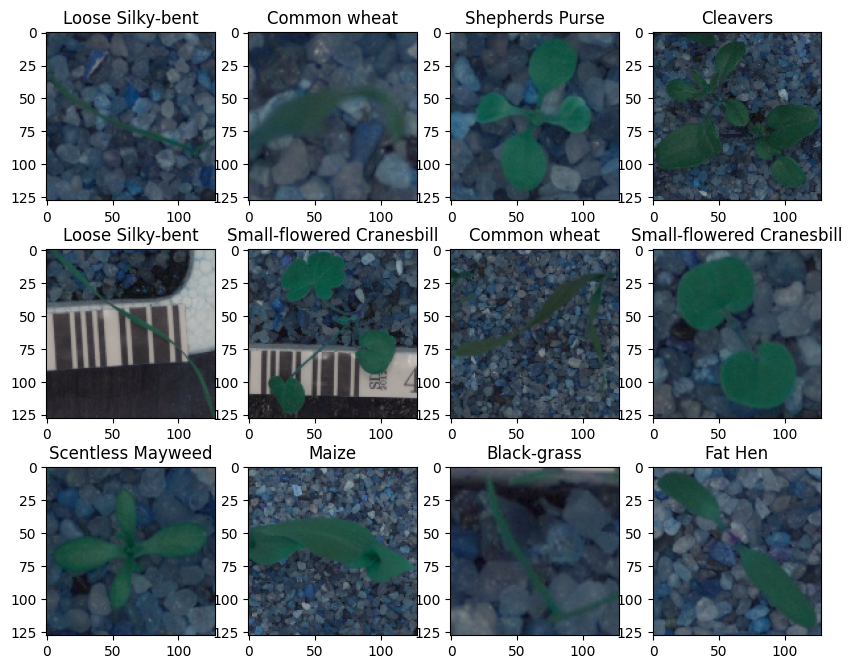

In [91]:
plot_images(images, labels)

#### Checking the distribution of the target variable

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

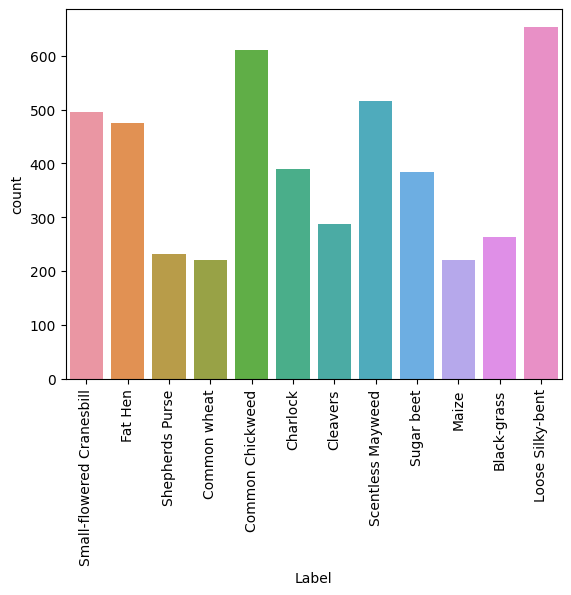

In [92]:
sns.countplot(x=labels['Label'])
plt.xticks(rotation='vertical')

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [93]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [94]:
images_decreased=[]
height = 64
width =  64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

**Image before resizing**

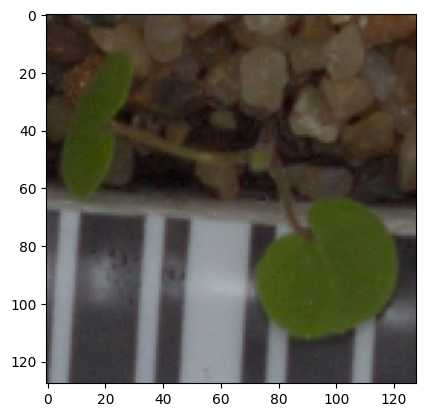

In [95]:
plt.imshow(images[10])

**Image after resizing**

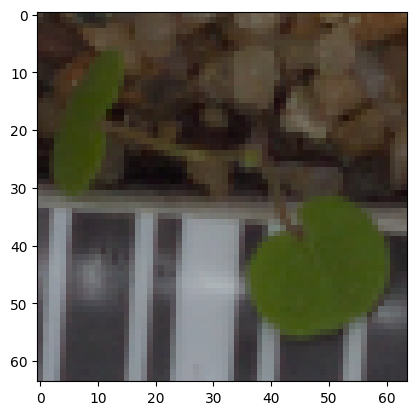

In [96]:
plt.imshow(images_decreased[10])

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [97]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased), labels, test_size=0.1, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [98]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Encode the target labels

In [99]:
# Convert labels from names to one hot vectors.
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [100]:
y_train_encoded.shape, y_val_encoded.shape, y_test_encoded.shape

((3847, 12), (428, 12), (475, 12))

### Data Normalization
Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [101]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32') / 255.0
X_val_normalized = X_val.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

## Model Building

In [102]:
# Clearing backend
backend.clear_session()

In [103]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [104]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 128 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

# Create two similar convolution and max-pooling layers activation = relu
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# Flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Add a fully connected dense layer with 16 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))

# Add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

#### Fitting the model on training data

In [105]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 3s - loss: 2.4543 - accuracy: 0.1068 - val_loss: 2.4382 - val_accuracy: 0.1379 - 3s/epoch - 26ms/step
Epoch 2/30
121/121 - 1s - loss: 2.4332 - accuracy: 0.1310 - val_loss: 2.4184 - val_accuracy: 0.1542 - 1s/epoch - 9ms/step
Epoch 3/30
121/121 - 1s - loss: 2.2875 - accuracy: 0.2386 - val_loss: 1.9774 - val_accuracy: 0.3621 - 1s/epoch - 9ms/step
Epoch 4/30
121/121 - 1s - loss: 1.9963 - accuracy: 0.3161 - val_loss: 1.8825 - val_accuracy: 0.3575 - 1s/epoch - 9ms/step
Epoch 5/30
121/121 - 1s - loss: 1.8820 - accuracy: 0.3260 - val_loss: 1.7059 - val_accuracy: 0.4346 - 1s/epoch - 10ms/step
Epoch 6/30
121/121 - 1s - loss: 1.7909 - accuracy: 0.3512 - val_loss: 1.6319 - val_accuracy: 0.4369 - 1s/epoch - 11ms/step
Epoch 7/30
121/121 - 1s - loss: 1.7287 - accuracy: 0.3943 - val_loss: 1.4757 - val_accuracy: 0.5187 - 1s/epoch - 12ms/step
Epoch 8/30
121/121 - 1s - loss: 1.6376 - accuracy: 0.4172 - val_loss: 1.3268 - val_accuracy: 0.5607 - 1s/epoch - 10ms/step
Epoch 9/30
121/121 

#### Evaluate the model

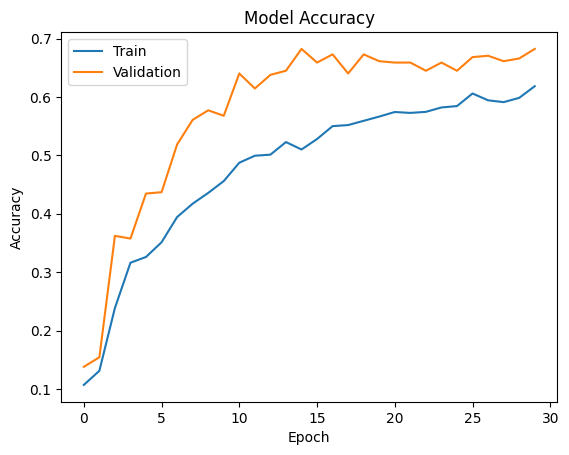

In [106]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations**:
- We can see from the above plot that the validation accuracy was good compared to the training data
- This implies that the model does not suffer overfitting

#### Evaluating the model on test data

In [107]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.0134 - accuracy: 0.6884 - 75ms/epoch - 5ms/step


#### Generating the predictions using test data

In [108]:
# Here we would get the output as probablities for each category
y_pred = model.predict(X_test_normalized)

15/15 [==============================] - 0s 4ms/step


In [109]:
y_pred

array([[1.29985943e-18, 2.04734409e-13, 3.27883476e-18, ...,
        1.68693960e-02, 8.36328619e-14, 4.76797693e-04],
       [1.26825536e-12, 1.08534828e-01, 9.29876883e-03, ...,
        2.50572711e-02, 8.41872752e-01, 6.60601305e-03],
       [3.70891963e-11, 1.04425073e-01, 5.92015823e-03, ...,
        3.78897525e-02, 8.34933102e-01, 6.96021784e-03],
       ...,
       [2.43226811e-01, 7.06398273e-09, 7.62068492e-04, ...,
        1.19295080e-08, 7.06506427e-08, 2.56407214e-03],
       [3.07203729e-09, 1.20376004e-04, 4.76221157e-06, ...,
        3.12373303e-02, 3.44500023e-07, 1.37722671e-01],
       [4.32126279e-10, 4.50836204e-04, 3.22130363e-05, ...,
        4.29267853e-01, 8.65602691e-04, 2.81543463e-01]], dtype=float32)

#### Plotting the confusion matrix

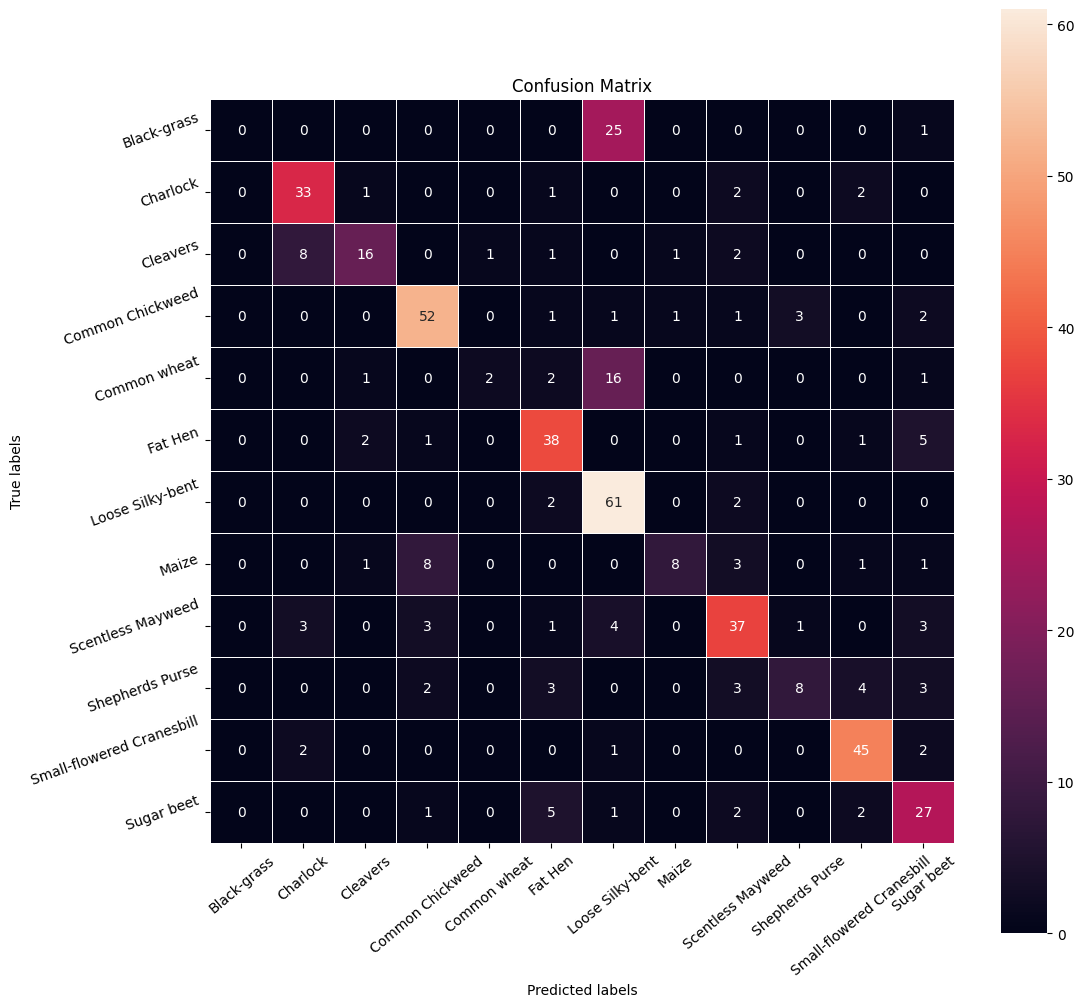

In [110]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

**Observations**:
- We observe that some of the classes are incorrectly predicted
- In comparison to the rest, we can see that Loose Silky-bent and Small-flowered Cranesbill are well classified

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [111]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(
          monitor='val_accuracy',
          patience=3,
          verbose=1,
          factor=0.5,
          min_lr=0.00001
    )


### **Data Augmentation**

In [112]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [113]:
# Set the rotation_range to 20
train_datagen = ImageDataGenerator(
             rotation_range=20,
             fill_mode='nearest'
        )

In [114]:
# Intializing a sequential model
model2 = Sequential()

# Add the first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Add max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))

model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# Flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))

# Add dropout with dropout_rate=0.3
model2.add(Dropout(0.3))
# Add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(12, activation='softmax'))

# Initialize Adam Optimimzer
opt = Adam()

# Compile the model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

#### Fitting the model on the train data

In [115]:
epochs = 30
batch_size = 64

history = model2.fit(
                        train_datagen.flow(X_train_normalized,y_train_encoded,
                        batch_size=batch_size,
                        shuffle=False),
                        epochs=epochs,
                        steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                        validation_data=(X_val_normalized,y_val_encoded),
                        verbose=1,callbacks=[learning_rate_reduction]
                     )

Epoch 1/30
60/60 [==============================] - 7s 95ms/step - loss: 2.1235 - accuracy: 0.2567 - val_loss: 2.3821 - val_accuracy: 0.2150 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 5s 89ms/step - loss: 1.6692 - accuracy: 0.4084 - val_loss: 2.2695 - val_accuracy: 0.2687 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 7s 109ms/step - loss: 1.4818 - accuracy: 0.4734 - val_loss: 2.1848 - val_accuracy: 0.2336 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 5s 76ms/step - loss: 1.3882 - accuracy: 0.5139 - val_loss: 2.1762 - val_accuracy: 0.3785 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 6s 107ms/step - loss: 1.3067 - accuracy: 0.5424 - val_loss: 1.8180 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 5s 78ms/step - loss: 1.2111 - accuracy: 0.5652 - val_loss: 1.6503 - val_accuracy: 0.4626 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 6s 100ms/step - loss: 

#### Model evaluation

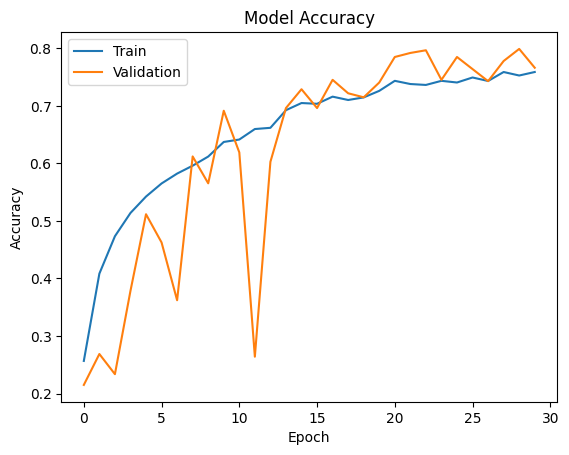

In [116]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Evaluate the model on test data

In [117]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.8112 - accuracy: 0.7600 - 79ms/epoch - 5ms/step


**Observation**:
- The accuracy of the model has improved compared to our previous model

#### Generating the predictions using the test data

In [118]:
# Here we would get the output as probablities for each category
y_pred = model.predict(X_test_normalized)

15/15 [==============================] - 0s 4ms/step


In [119]:
y_pred

array([[1.29985943e-18, 2.04734409e-13, 3.27883476e-18, ...,
        1.68693960e-02, 8.36328619e-14, 4.76797693e-04],
       [1.26825536e-12, 1.08534828e-01, 9.29876883e-03, ...,
        2.50572711e-02, 8.41872752e-01, 6.60601305e-03],
       [3.70891963e-11, 1.04425073e-01, 5.92015823e-03, ...,
        3.78897525e-02, 8.34933102e-01, 6.96021784e-03],
       ...,
       [2.43226811e-01, 7.06398273e-09, 7.62068492e-04, ...,
        1.19295080e-08, 7.06506427e-08, 2.56407214e-03],
       [3.07203729e-09, 1.20376004e-04, 4.76221157e-06, ...,
        3.12373303e-02, 3.44500023e-07, 1.37722671e-01],
       [4.32126279e-10, 4.50836204e-04, 3.22130363e-05, ...,
        4.29267853e-01, 8.65602691e-04, 2.81543463e-01]], dtype=float32)

#### Plotting the confusion matrix

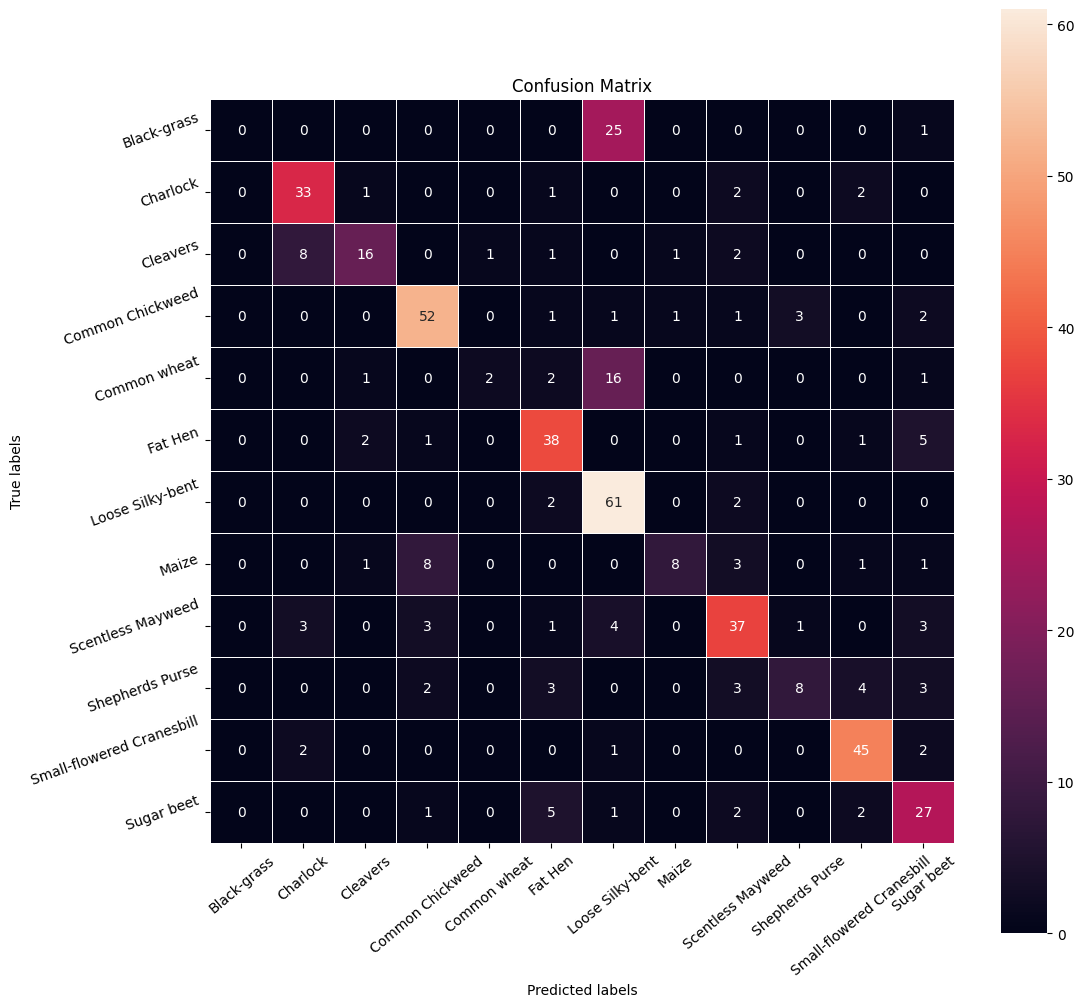

In [120]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

#### Plotting classification report

In [121]:
from sklearn import metrics

cr = metrics.classification_report(y_test_arg, y_pred_arg)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.72      0.85      0.78        39
           2       0.76      0.55      0.64        29
           3       0.78      0.85      0.81        61
           4       0.67      0.09      0.16        22
           5       0.70      0.79      0.75        48
           6       0.56      0.94      0.70        65
           7       0.80      0.36      0.50        22
           8       0.70      0.71      0.70        52
           9       0.67      0.35      0.46        23
          10       0.82      0.90      0.86        50
          11       0.60      0.71      0.65        38

    accuracy                           0.69       475
   macro avg       0.65      0.59      0.58       475
weighted avg       0.66      0.69      0.65       475



## Final Model

- We can observe from the confusion matrix of the two models (model and model2) that the model that with a reduced learning rate (i.e model2) was the better model because it predicted majority of the classes better than the other model.
- The test accuracy of the second model was about 75%
- Data augmentation also helped in improving the model

### Visualizing the prediction

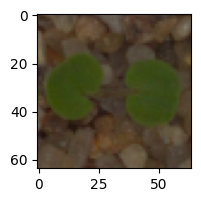

1/1 [==============================] - 0s 70ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


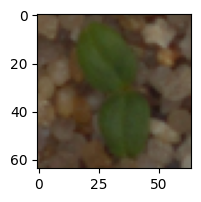

1/1 [==============================] - 0s 21ms/step
Predicted Label ['Cleavers']
True Label Cleavers


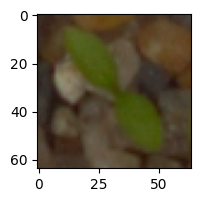

1/1 [==============================] - 0s 20ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


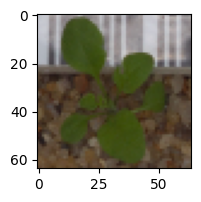

1/1 [==============================] - 0s 21ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [122]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()

# Predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                                # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()

# Predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()

# Predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()

# Predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                               # using inverse_transform() to get the output label from the output vector

## Actionable Insights and Business Recommendations

- These models can be further improved by training with different filter sizes and different number of filters.
- These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64.
- Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance.
- Employing the transfer learning model can produce a better outcome than the ordinary CNN.

_____